In [156]:
import pandas as pd
import numpy as np

import os
import sys
import glob
# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import math
import random
import time

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras import Model
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, Activation, Input, MaxPooling2D, Reshape, Concatenate,AveragePooling1D
# from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import Sequence, to_categorical
import tensorflow as tf
import seaborn as sns

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [157]:
# Paths for data.
Ravdess = "input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"

In [158]:
ravdess_directory_list = os.listdir(Ravdess)
file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
data_path = Ravdess_df

In [200]:
data_path.iloc[:20,:]

,Emotions,Path
0,angry,input/ravdess-emotional-speech-audio/audio_spe...
1,fear,input/ravdess-emotional-speech-audio/audio_spe...
2,fear,input/ravdess-emotional-speech-audio/audio_spe...
3,angry,input/ravdess-emotional-speech-audio/audio_spe...
4,disgust,input/ravdess-emotional-speech-audio/audio_spe...
5,sad,input/ravdess-emotional-speech-audio/audio_spe...
6,sad,input/ravdess-emotional-speech-audio/audio_spe...
7,disgust,input/ravdess-emotional-speech-audio/audio_spe...
8,surprise,input/ravdess-emotional-speech-audio/audio_spe...
9,surprise,input/ravdess-emotional-speech-audio/audio_spe...


In [326]:
data_dict = {"angry": data_path.iloc[0,1],"calm": data_path.iloc[12,1], "sad": data_path.iloc[5,1],"happy":data_path.iloc[10,1],"disgust":data_path.iloc[4,1]}

In [202]:
#preprocesing inputs for frame level classifier

def preprocess_data(data):

    X = []
    res1 = adjust_length(data,2.5)
    res1 = divide_into_frames(res1)
    X.append(res1)
        
    return X
def adjust_length(data,length):
    if len(data)> 22050*length:
        midpoint = int(len(data)/2)
        left_index = midpoint - int(length*22050/2)
        return data[left_index:left_index+int(length*22050)]
    else:
        edge = int(22050*length - len(data))
        return np.pad(data,pad_width=(edge-int(edge/2),int(edge/2)),mode="constant")

def apply_weights(model,weights):
    layer_index = 0
    for layer in model.layers[1:]:
        layer.set_weights([weights[layer_index],weights[layer_index+1]])
        layer_index+=2
    return model

def divide_into_frames(data,frame_length=2048, hop_length = 512):
    output = []
    n_frame = math.ceil(len(data)/hop_length)
    for i in range(n_frame-1):
        start_index = i * hop_length
        if start_index + frame_length > len(data):
            end_index = len(data)-hop_length*(n_frame-i)
            f = data[end_index-frame_length:end_index]
            f = f.reshape(1,2048)
            output.append(f)
        else:
            f = data[start_index:start_index+frame_length]
            f = f.reshape(1,2048)
            output.append(f)
    f = data[frame_length*(-1):]
    f = f.reshape(1,2048)
    output.append(f)
    return np.array(output)

In [203]:
#preprocesing inputs for ensemble model classifier

def preprocess_data_collective(data):

    X = []
    res1 = adjust_length(data,2.5)
    res1 = divide_into_frames_collective(res1)
    X.append(res1)
        
    return X

def divide_into_frames_collective(data,frame_length=2048, hop_length = 512):
    output = []
    n_frame = math.ceil(len(data)/hop_length)
    for i in range(n_frame-1):
        start_index = i * hop_length
        if start_index + frame_length > len(data):
            end_index = len(data)-hop_length*(n_frame-i)
            f = data[end_index-frame_length:end_index]
#             f = f.reshape(1,2048)
            output.append(f)
        else:
            f = data[start_index:start_index+frame_length]
#             f = f.reshape(1,2048)
            output.append(f)
    f = data[frame_length*(-1):]
#     f = f.reshape(1,2048)
    output.append(f)
    return np.array(output)

In [345]:
def visualize_1():
    audio_x = np.arange(55125)/22050
    fig , ax = plt.subplots(3,1)
    fig.set_size_inches(20,20)

    ax[0].plot(audio_x, np.array(trimmed)  , label = 'audio',linewidth=3)
    ax[0].tick_params(axis='both',labelsize=15)
    ax[0].set_xlabel("Seconds",fontsize=20)
    ax[0].set_ylabel("Amplitude",fontsize=20)

    ax[1].plot(np.arange(108) , prob, label = 'prob',linewidth=3)
    ax[1].tick_params(axis='both',labelsize=15)
    ax[1].set_xlabel("Probability of correct emotion " + emotion,fontsize=20)
    ax[1].set_ylabel("Prob",fontsize=20)
    
    ax[2].plot(np.arange(108) , wrong_prob_1, label = 'prob',linewidth=3,color="orange")
    ax[2].tick_params(axis='both',labelsize=15)
    ax[2].set_xlabel("Probability of wrong emotion " + emotions[wrong_label_1],fontsize=20)
    ax[2].set_ylabel("Prob",fontsize=20)

### Build model

In [283]:
trained_model = load_model("consolidated_trainable")
weights = trained_model.get_weights()

In [284]:
inputs = Input(shape=(1,2048),name="consolidated_input")
# #zcr
zcr_input = Reshape(target_shape=(1,2048,1))(inputs)
zcr_x = Conv1D(16,kernel_size=16, strides=4, padding='valid', activation='relu',name = "zcr_1")(zcr_input)
zcr_x = Reshape(target_shape=(1,509*16),name="zcr_reshape")(zcr_x)
zcr_x = Dense(32,activation="relu", name="zcr_2")(zcr_x)
zcr_x = Dense(32,activation="relu", name="zcr_3")(zcr_x)
zcr_x = Dense(32,activation="relu", name="zcr_4")(zcr_x)
zcr_outputs = Dense(1,activation="relu", name="zcr_output")(zcr_x)

# #chroma
chroma_input = Reshape(target_shape=(1,2048,1))(inputs)
chroma_x = Conv1D(256,kernel_size=512, strides=1, padding='valid', activation='relu',name = "chroma_1")(chroma_input)
chroma_x = MaxPooling2D(pool_size=(1,256), strides = (1,128), padding = 'valid',name="chroma_max")(chroma_x)
chroma_x = Reshape(target_shape=(1,11*256),name="chroma_reshape")(chroma_x)
chroma_x = Dense(256,activation="relu", name="chroma_2")(chroma_x)
chroma_x = Dense(128,activation="relu", name="chroma_3")(chroma_x)
chroma_x = Dense(64,activation="relu", name="chroma_4")(chroma_x)
chroma_outputs = Dense(12,activation="relu", name="chroma"+"_output")(chroma_x)

# #rms
rms_dense = Dense(32, activation="relu", name = "rms"+"_1")
rms_x = rms_dense(inputs)
rms_x = Dense(16, activation="relu",name = "rms"+"_2")(rms_x)
rms_x = Dense(8, activation="relu",name = "rms"+"_3")(rms_x)
rms_outputs = Dense(1, activation="relu",name="rms"+"_output")(rms_x)
rms_outputs = Reshape(target_shape=(1,1))(rms_outputs)


#melspectrogram
melspectrogram_input = Reshape(target_shape=(1,2048,1))(inputs)
melspectrogram_x = Conv1D(512,kernel_size=512, strides=1, padding='valid', activation='relu',name = "melspectrogram"+"_1")(melspectrogram_input)
melspectrogram_x = MaxPooling2D(pool_size=(1,256), strides = (1,128), padding = 'valid',name="melspectrogram_max")(melspectrogram_x)
melspectrogram_x = Reshape(target_shape=(1,11*512),name="melspectrogram_reshape")(melspectrogram_x)
melspectrogram_outputs = Dense(128,activation="relu", name="melspectrogram"+"_output")(melspectrogram_x)

#mfcc
mfcc_input = Reshape(target_shape=(1,2048,1))(inputs)
mfcc_x = Conv1D(256,kernel_size=512, strides=1, padding='valid', activation='relu',name = "mfcc"+"_1")(mfcc_input)
mfcc_x = MaxPooling2D(pool_size=(1,512), strides = (1,110), padding = 'valid',name="mfcc_max")(mfcc_x)
mfcc_x = Reshape(target_shape=(1,10*256),name="mfcc_reshape")(mfcc_x)
mfcc_x = Dense(256, activation="relu",name = "mfcc"+"_2")(mfcc_x)
mfcc_x = Dense(128, activation="relu",name = "mfcc"+"_3")(mfcc_x)
mfcc_outputs = Dense(20,activation="linear", name="mfcc"+"_output")(mfcc_x)
concat = Concatenate()([zcr_outputs,chroma_outputs,mfcc_outputs,rms_outputs,melspectrogram_outputs])

feature_output = AveragePooling1D(pool_size=1)(concat)
feature_output = Reshape(target_shape=(162,1))(feature_output)

layer = BatchNormalization()(feature_output)
layer = Conv1D(256, 8, padding='same')(layer)
layer = Activation('relu')(layer)
layer = Conv1D(256, 8, padding='same')(layer)
layer = BatchNormalization()(layer)
layer = Activation('relu')(layer)
layer = Dropout(0.25)(layer)
layer = MaxPooling1D(pool_size=(8))(layer)
layer = Conv1D(128, 8, padding='same')(layer)
layer = Activation('relu')(layer)
layer = Conv1D(128, 8, padding='same')(layer)
layer = Activation('relu')(layer)
layer = Conv1D(128, 8, padding='same')(layer)
layer = Activation('relu')(layer)
layer = Conv1D(128, 8, padding='same')(layer)
layer = BatchNormalization()(layer)
layer = Activation('relu')(layer)
layer = Dropout(0.25)(layer)
layer = MaxPooling1D(pool_size=(8))(layer)
layer = Conv1D(64, 8, padding='same')(layer)
layer = Activation('relu')(layer)
layer = Conv1D(64, 8, padding='same')(layer)
layer = Activation('relu')(layer)
layer = Flatten()(layer)
layer = Dense(8)(layer) # Target class number
layer = Activation('softmax')(layer)
model = Model(inputs=inputs, outputs=layer)

#apply weights


model.compile(optimizer = "adam" , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
print("compiled model")

compiled model


In [285]:
model.set_weights(weights)

### Load and preprocess sample data

In [393]:
emotion= "disgust" 
threshold = 0.8
emotions = ['angry','calm','disgust','fear','happy','neutral','sad','surprise']
emotion_dict = {'angry':0,'calm':1,'disgust':2,'fear':3,'happy':4,'neutral':5,'sad':6,'surprise':7}
emotion_code = emotion_dict[emotion]

In [394]:
sample_path = data_dict[emotion]
sample_path

'input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_16/03-01-07-01-01-01-16.wav'

In [395]:
sample_data, sr = librosa.load(sample_path)

In [396]:
x = preprocess_data(sample_data)
x_collective = preprocess_data_collective(sample_data)
trimmed = adjust_length(sample_data,2.5)

In [397]:
x[0].shape

(108, 1, 2048)

### Make frame-level predictions

In [398]:
pred = model.predict(x[0])
pred

array([[1.86390228e-08, 1.07302430e-05, 2.76502362e-03, 5.23872897e-02,
        1.64625007e-08, 1.44532620e-04, 9.44691598e-01, 7.79069808e-07],
       [1.84989268e-08, 1.06371381e-05, 2.77475873e-03, 5.25293909e-02,
        1.64418044e-08, 1.43436700e-04, 9.44541037e-01, 7.74144553e-07],
       [1.81554007e-08, 1.03892799e-05, 2.78107938e-03, 5.26469871e-02,
        1.63530895e-08, 1.41493976e-04, 9.44419324e-01, 7.54652433e-07],
       [1.80899615e-08, 1.03462571e-05, 2.78063980e-03, 5.26318103e-02,
        1.63232308e-08, 1.41169105e-04, 9.44435239e-01, 7.50849608e-07],
       [1.80899615e-08, 1.03462571e-05, 2.78063980e-03, 5.26318103e-02,
        1.63232308e-08, 1.41169105e-04, 9.44435239e-01, 7.50849608e-07],
       [1.80899615e-08, 1.03462571e-05, 2.78063980e-03, 5.26318103e-02,
        1.63232308e-08, 1.41169105e-04, 9.44435239e-01, 7.50849608e-07],
       [1.81110007e-08, 1.03637731e-05, 2.78006634e-03, 5.26152402e-02,
        1.63247691e-08, 1.41323850e-04, 9.44452167e-01, 7.

In [399]:
prob = [i[emotion_code] for i in pred]
prob

[0.0027650236,
 0.0027747587,
 0.0027810794,
 0.0027806398,
 0.0027806398,
 0.0027806398,
 0.0027800663,
 0.0027698884,
 0.0027362953,
 0.0026431398,
 0.0029044747,
 0.0029642147,
 0.0026909907,
 0.40417898,
 0.992253,
 0.99986804,
 0.9819857,
 0.54184425,
 0.4323107,
 0.99967504,
 0.03055808,
 4.5178257e-14,
 2.1194364e-14,
 6.656367e-06,
 0.9992467,
 0.99956757,
 0.96876186,
 4.40819e-05,
 0.00031233416,
 0.00014757668,
 0.03552442,
 0.00596077,
 0.3497079,
 0.9600144,
 0.9511974,
 0.99979454,
 0.9999603,
 0.99418503,
 0.97917527,
 0.99105036,
 0.9944313,
 0.727394,
 4.563004e-05,
 0.633508,
 0.00217426,
 3.3467313e-09,
 0.0024737427,
 0.5732878,
 0.33445024,
 0.9653767,
 0.9682428,
 0.9705663,
 0.9975489,
 0.99401146,
 0.13373037,
 0.4753567,
 0.7842515,
 0.4719622,
 0.08493515,
 0.11003181,
 0.74994075,
 0.79398125,
 0.9997118,
 0.06677717,
 0.022937708,
 0.037090957,
 0.12685212,
 0.9301251,
 0.20141883,
 0.3178428,
 0.040873796,
 0.010427693,
 0.0020483052,
 0.28845194,
 0.872316

In [405]:
wrong_label_1 = -1
wrong_label_2 = -1
if emotion == "angry":
    wrong_label_1 = 1
    wrong_label_2 = 4
elif emotion == "calm":
    wrong_label_1 = 0
    wrong_label_2 = 4
elif emotion == "happy":
    wrong_label_1 = 1
    wrong_label_2 = 0
elif emotion == "sad":
    wrong_label_1 = 0
    wrong_label_2 = 1
elif emotion == "disgust":
    wrong_label_1 = 0
    wrong_label_2 = 1

wrong_prob_1 = [i[wrong_label_1] for i in pred]
wrong_prob_2 = [i[wrong_label_2] for i in pred]

In [406]:
qualified_frames = np.where(np.array(prob) > threshold, 1, 0)
qualified_frames

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### Audio Level Prediction

In [407]:
res = trained_model.predict(np.array(x_collective))
audio_pred = emotions[res.argmax()]
audio_pred

'disgust'

### Visualize

In [408]:
Audio(np.array(trimmed), rate=sr)

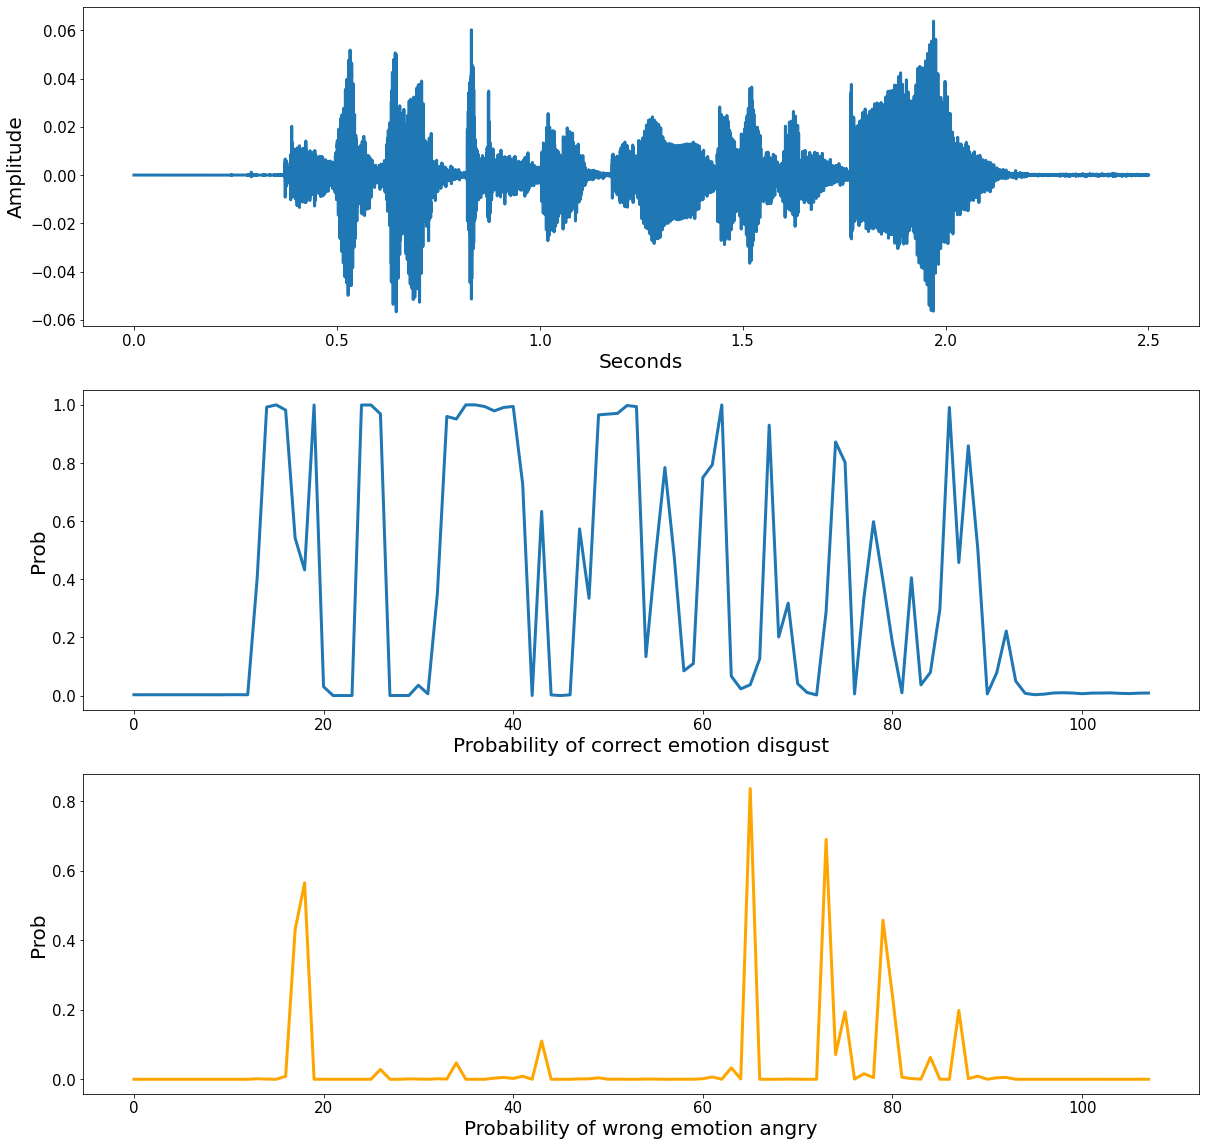

In [409]:
visualize_1()